# Guided Project: Creating a Kaggle Workflow

In this mission, we're going to explore a workflow to make competing in the Kaggle Titanic competition easier, using a pipeline of functions to reduce the number of dimensions you need to focus on.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')
holdout.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


Loading important functions, that will be used frequently in this project.

In [14]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [15]:
# A new function to apply all the functions above to our data
def applyfn(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    dumm_cols = ['Age_categories', 'Fare_categories', 'Title', 'Cabin_type', 'Sex']
    for col in dumm_cols:
        df = create_dummies(df, col)
        
    return df

In [16]:
train = applyfn(train)
holdout = applyfn(holdout)

In [17]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Sex_female,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,0,0,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,1,0,0,0,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,0,0,1,1,0


### Feature Engineering

Lets explore  the two columns that contain information about the family members each passenger had onboard: SibSp and Parch. "Parch" column contains the number of children of parents aboard the ship, "SibSp" contains the number of sibling or Spouse aboard.

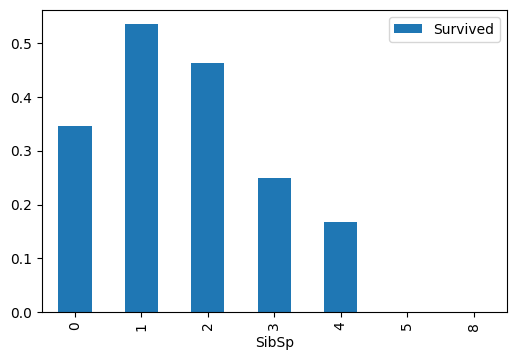

In [18]:
train.pivot_table(index = 'SibSp', values = 'Survived').plot.bar()

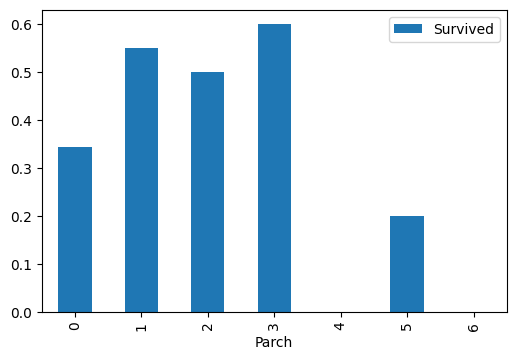

In [19]:
train.pivot_table(index = 'Parch', values = 'Survived').plot.bar()

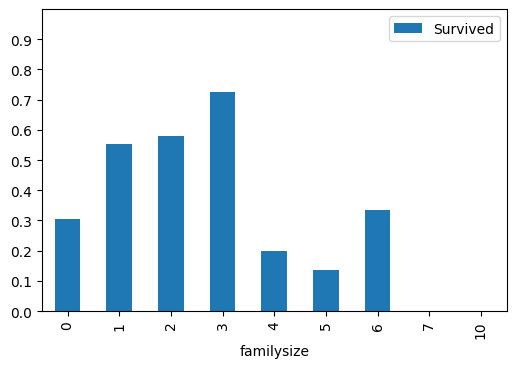

In [20]:
explore_cols = ["SibSp","Parch","Survived"]
explore = train[explore_cols].copy()

explore['familysize'] = explore[["SibSp","Parch"]].sum(axis=1)
pivot = explore.pivot_table(index='familysize',values="Survived")
pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
plt.show()

So, generally people with one or two Spouse or sibling on board have the highest survival rate followed by those with none, then survival chances decreases as 'SibSp' increases. Then those with 3, 1 or 2 parents/ children also have high survival rate. But in a combined column, survival increase as relative increase up till 3 then drop as number increases. About 30% of people with no relative aboard survived.
Based of this, we can come up with an idea for a new feature - was the passenger alone. This will be a binary column containing the value:

    1 if the passenger has zero family members onboard
    0 if the passenger has one or more family members onboard

In [21]:
def process_isalone(df):
    df["familysize"] = df[["SibSp","Parch"]].sum(axis=1)
    df["isalone"] = 0
    df.loc[(df["familysize"] == 0),"isalone"] = 1
    df = df.drop("familysize",axis=1)
    return df

train = process_isalone(train)
holdout = process_isalone(holdout)

In [25]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Sex_female,Sex_male,isalone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,0,1,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,1,0,0,0,0,0,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,0,1,1,0,1


### Feature Selection

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

In [43]:
def select_features(df):
    df = df.select_dtypes(include = 'number').dropna(axis =1)
    all_x = df.drop(['PassengerId', 'Survived'], axis =1)
    all_y = df['Survived']
    
    rf = RandomForestClassifier(random_state =1)
    selector =RFECV(rf, cv = 10)
    selector.fit(all_x, all_y)
    optimized_columns = list(all_x.columns[selector.support_])
    return optimized_columns

In [44]:
optimized_feats =select_features(train)
print(optimized_feats)

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Child', 'Age_categories_Teenager', 'Age_categories_Young Adult', 'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12', 'Fare_categories_12-50', 'Fare_categories_50-100', 'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'isalone']


The columns above are the best features for our model, using the scikit_learn feature selection module.

### Model Selection

Just like we did with feature selection, we can write a function to do the heavy lifting of model selection and tuning. The function we'll create will use three different algorithms and use grid search to train using different combinations of hyperparameters to find the best performing model.

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [51]:
def select_model(df, features):
    all_x = df[features]
    all_y = df['Survived']
    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(max_iter = 1000),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [4, 6, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]

                }
        }
    ]

    for model in models:
        print(model['name'])
        print('-'*len(model['name']))

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10)
        grid.fit(all_x,all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models

In [52]:
result = select_model(train,optimized_feats)

LogisticRegression
------------------
Best Score: 0.8204619225967541
Best Parameters: {'solver': 'newton-cg'}

KNeighborsClassifier
--------------------
Best Score: 0.7767041198501874
Best Parameters: {'algorithm': 'brute', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}

RandomForestClassifier
----------------------
Best Score: 0.8395505617977527
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 6}



The best performing model from the results above is the RandomforestClassifier. With an accuracy of 83%. This could be better by further feature engineering and selection. And making sure we are not overfitting. 

For now lets make predictions and submit to Kaggle to see the score before deciding if to continue working on model.

In [58]:
def save_submission_file(trained_model, features, filename = 'submission.csv'):
    predictions = trained_model.predict(holdout[features])
    submission_df = {"PassengerID":holdout["PassengerId"],
                    "Survived":predictions}
    submission = pd.DataFrame(submission_df)
    submission.to_csv(filename, index = False)

In [59]:
# Making predictions for submission using best random_forest model
save_submission_file(result[2]['best_model'], optimized_feats)